In [0]:
try:
    %tensorflow_version 1.x
except exception:
    pass

!ls

TensorFlow 1.x selected.
ChessboardTest2  gdrive  __MACOSX  sample_data


In [0]:
from google.colab import drive
import logging
import os
import random
import sys
from collections import deque

In [0]:
path = '/content/gdrive'
drive.mount(path)
path += '/My Drive/ARVision Data'

sys.path.insert(0, path)
sys.path.insert(0, path + '/AR3DVision')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.contrib.slim as slim
from nets.mobilenet import mobilenet_v2

BATCH_SIZE = 32
IMAGE_SIZE = 224

iter = 100000
lr = 0.001

checkpoint_name = path + '/mobilenet_v2_1_0_224/mobilenet_v2_1.0_224.ckpt'
ckpt_dir = path + '/AR3DVision/checkpoints'

tf.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'1.15.2'

In [0]:
!nvidia-smi
tf.test.gpu_device_name()

Tue Apr 21 03:57:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

'/device:GPU:0'

In [0]:
def set_random_seed():
    seed = random.randrange(2 ** 32 - 2)
    logging.info('Using random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed + 1)
    tf.set_random_seed(seed + 2)
    
set_random_seed()

In [0]:
from dataset_factory import ImageCollector, ImgInverNormalize
import matplotlib.pyplot as plt
from matplotlib import cm

In [0]:
zippath = "\"" + path + "/Training Data/Training Data.zip" + "\""
!unzip -q $zippath

replace __MACOSX/._ChessboardTest2? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# !rm -r ChessboardTest2
!ls

ChessboardTest2  gdrive  __MACOSX  sample_data


In [0]:
dataset = ImageCollector("ChessboardTest2", 1, 1000, 32, False) # Real data
dataset.StartLoadData()

module name: dataset_factory
parent process: 24
process id: 1145


In [0]:
train_data = dataset.getLoadedData()

max : 0.7333333333333334
min : -0.9921568627450981


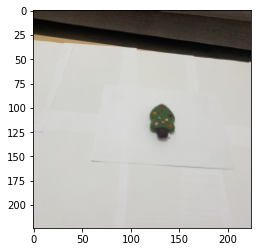

In [0]:
print("max : " + str(train_data[1][0].max()))
print("min : " + str(train_data[1][0].min()))

plt.imshow(ImgInverNormalize(train_data[1][0], 1.))
# plt.imshow(train_data[1][0])
plt.show()

In [0]:
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

input_img = tf.placeholder(tf.float32, [None] + [IMAGE_SIZE, IMAGE_SIZE, 3])
input_label = tf.placeholder(tf.float32, [None] + [6])

In [0]:
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope()):
    logits, endpoints = mobilenet_v2.mobilenet(input_img, num_classes=6)
    
cost = tf.reduce_mean(tf.square(endpoints['6DOF'] - input_label))
train_op = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(cost)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="MobilenetV2")
reuse_var_refine = [var for var in reuse_vars if '6DOF' not in var.name]

saver = tf.train.Saver(var_list=reuse_var_refine)

saver = tf.train.Saver(tf.global_variables())
ckpt = tf.train.get_checkpoint_state(ckpt_dir)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)

new_saver = tf.train.Saver()

saver.restore(sess, checkpoint_name)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/ARVision Data/AR3DVision/checkpoints/model_iter0.ckpt


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/ARVision Data/AR3DVision/checkpoints/model_iter0.ckpt


In [0]:
t = tqdm(range(iter))
loss_print = ""

for i in t:
    train_data = dataset.getLoadedData()
    t.set_description(loss_print)
    _, loss_val = sess.run([train_op, cost], feed_dict={input_img: train_data[1], input_label: train_data[2]})

    if i % 100 == 0:
        loss_print = 'Step: [' + str(i) + '/' + str(iter) + '], loss: ' + str(loss_val)
        break

    if i % 5000 == 0:
        new_saver.save(sess, ckpt_dir + '/model_iter' + str(i) + '.ckpt')


  0%|          | 0/100000 [00:00<?, ?it/s]

predict: [0.04043621 0.02772214 0.7025788  0.02186534 0.34522903 0.08184922]
train data: [ 0.0270001 -0.0310797  0.673893  -2.1405    -2.08249   -0.680865 ]


# Save Trained Model

In [0]:
save_dir = path + '/checkpoints'
save_path = os.path.join(save_dir, 'model.ckpt')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = new_saver.save(sess, save_path)
tf.train.write_graph(sess.graph, './', 'model.pbtxt')

# Valid model

In [0]:
temp_ckpt_dir = "\"" + ckpt_dir + "\""
!ls $temp_ckpt_dir

checkpoint
model_iter0.ckpt.data-00000-of-00001
model_iter0.ckpt.index
model_iter0.ckpt.meta
model_iter20000.ckpt.data-00000-of-00001
model_iter20000.ckpt.index
model_iter20000.ckpt.meta
model_iter25000.ckpt.data-00000-of-00001
model_iter25000.ckpt.index
model_iter25000.ckpt.meta
model_iter30000.ckpt.data-00000-of-00001
model_iter30000.ckpt.index
model_iter30000.ckpt.meta
model_iter35000.ckpt.data-00000-of-00001
model_iter35000.ckpt.index
model_iter35000.ckpt.meta
model_iter40000.ckpt.data-00000-of-00001
model_iter40000.ckpt.index
model_iter40000.ckpt.meta


In [0]:
sess = tf.Session()

with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(input_img, num_classes=6)

saver = tf.train.Saver(tf.global_variables())
ckpt = tf.train.get_checkpoint_state(ckpt_dir)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sys.exit("There is no trained model")

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/ARVision Data/AR3DVision/checkpoints/model_iter0.ckpt


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/ARVision Data/AR3DVision/checkpoints/model_iter0.ckpt


In [0]:
# graph = tf.get_default_graph()

with sess.as_default():
    train_data = dataset.getLoadedData()
    # x = endpoints['6DOF'].eval(feed_dict={input_img: train_data[1]})
    x = sess.run([endpoints['6DOF']], feed_dict={input_img: train_data[1]})
    print(x[0][0])
    print(train_data[2][0])

[-0.06156172 -0.00379598  0.7385935   0.71389353  0.21352738 -0.05816562]
[ 0.06782   0.097426  0.715136  1.88281   1.89898  -0.225752]


In [0]:
x[0]

array([ 0.35007402,  0.08021664, -0.00371772, -0.34739316,  1.9477999 ,
        1.8251897 ], dtype=float32)

In [0]:
np.linalg.norm(train_data[2][0]-x[0])

4.883568907535297